<a href="https://colab.research.google.com/github/badhan7700/project_sowrob/blob/main/Copy_of_TRAFICsign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GTSRB Traffic Sign Classification
**Simple CNN + MobileNetV2 Transfer Learning**

This notebook trains two models:
1. Simple CNN (from scratch)
2. MobileNetV2 (transfer learning)

---

## Part 1: Setup & Data Loading

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import os
import pickle
import random
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f'TensorFlow: {tf.__version__}')

TensorFlow: 2.19.0


In [ ]:
# Load Dataset
BASE_PATH = '/content/drive/MyDrive/TrafficSignProject/GTSRB'

def load_data(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return np.array(data['features']), np.array(data['labels'])

X_train, y_train = load_data(f'{BASE_PATH}/train.p')
X_valid, y_valid = load_data(f'{BASE_PATH}/valid.p')
X_test, y_test = load_data(f'{BASE_PATH}/test.p')

# Load class names
df_signs = pd.read_csv(f'{BASE_PATH}/signname.csv')
NUM_CLASSES = len(df_signs)
sign_names = dict(zip(df_signs.ClassId, df_signs.SignName))

print(f'Classes: {NUM_CLASSES}')
print(f'Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}')

Classes: 43
Train: (34799, 32, 32, 3), Valid: (4410, 32, 32, 3), Test: (12630, 32, 32, 3)


In [ ]:
# Preprocessing - Normalize to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode labels
y_train_oh = to_categorical(y_train, NUM_CLASSES)
y_valid_oh = to_categorical(y_valid, NUM_CLASSES)
y_test_oh = to_categorical(y_test, NUM_CLASSES)

print(f'Data range: [{X_train.min():.1f}, {X_train.max():.1f}]')

Data range: [0.0, 1.0]


## Part 2: Data Visualization

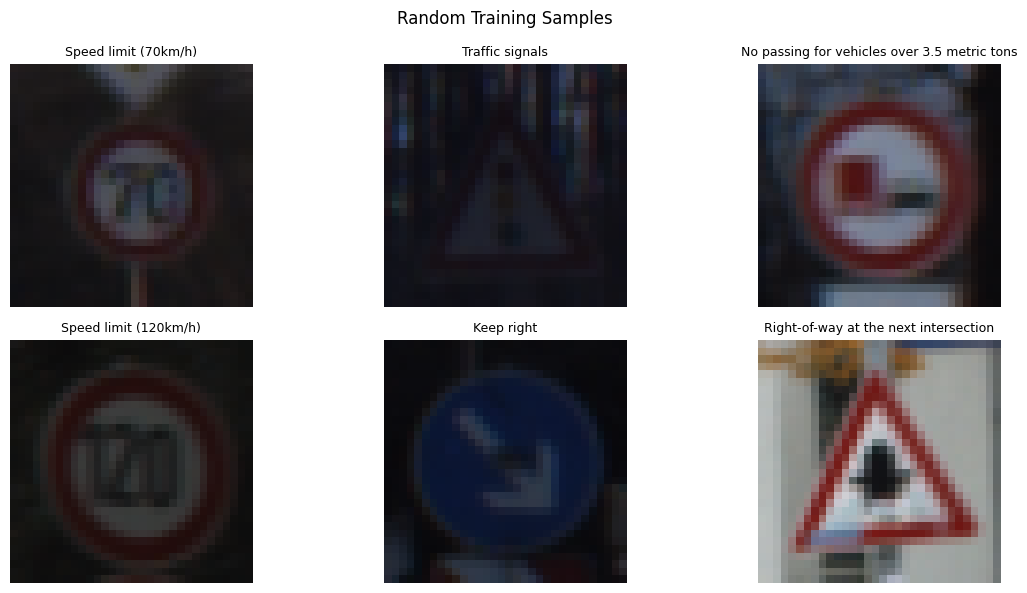

In [ ]:
# Show random samples
plt.figure(figsize=(12, 6))
for i in range(6):
    idx = random.randint(0, len(X_train)-1)
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[idx])
    plt.title(sign_names[y_train[idx]], fontsize=9)
    plt.axis('off')
plt.suptitle('Random Training Samples')
plt.tight_layout()
plt.show()

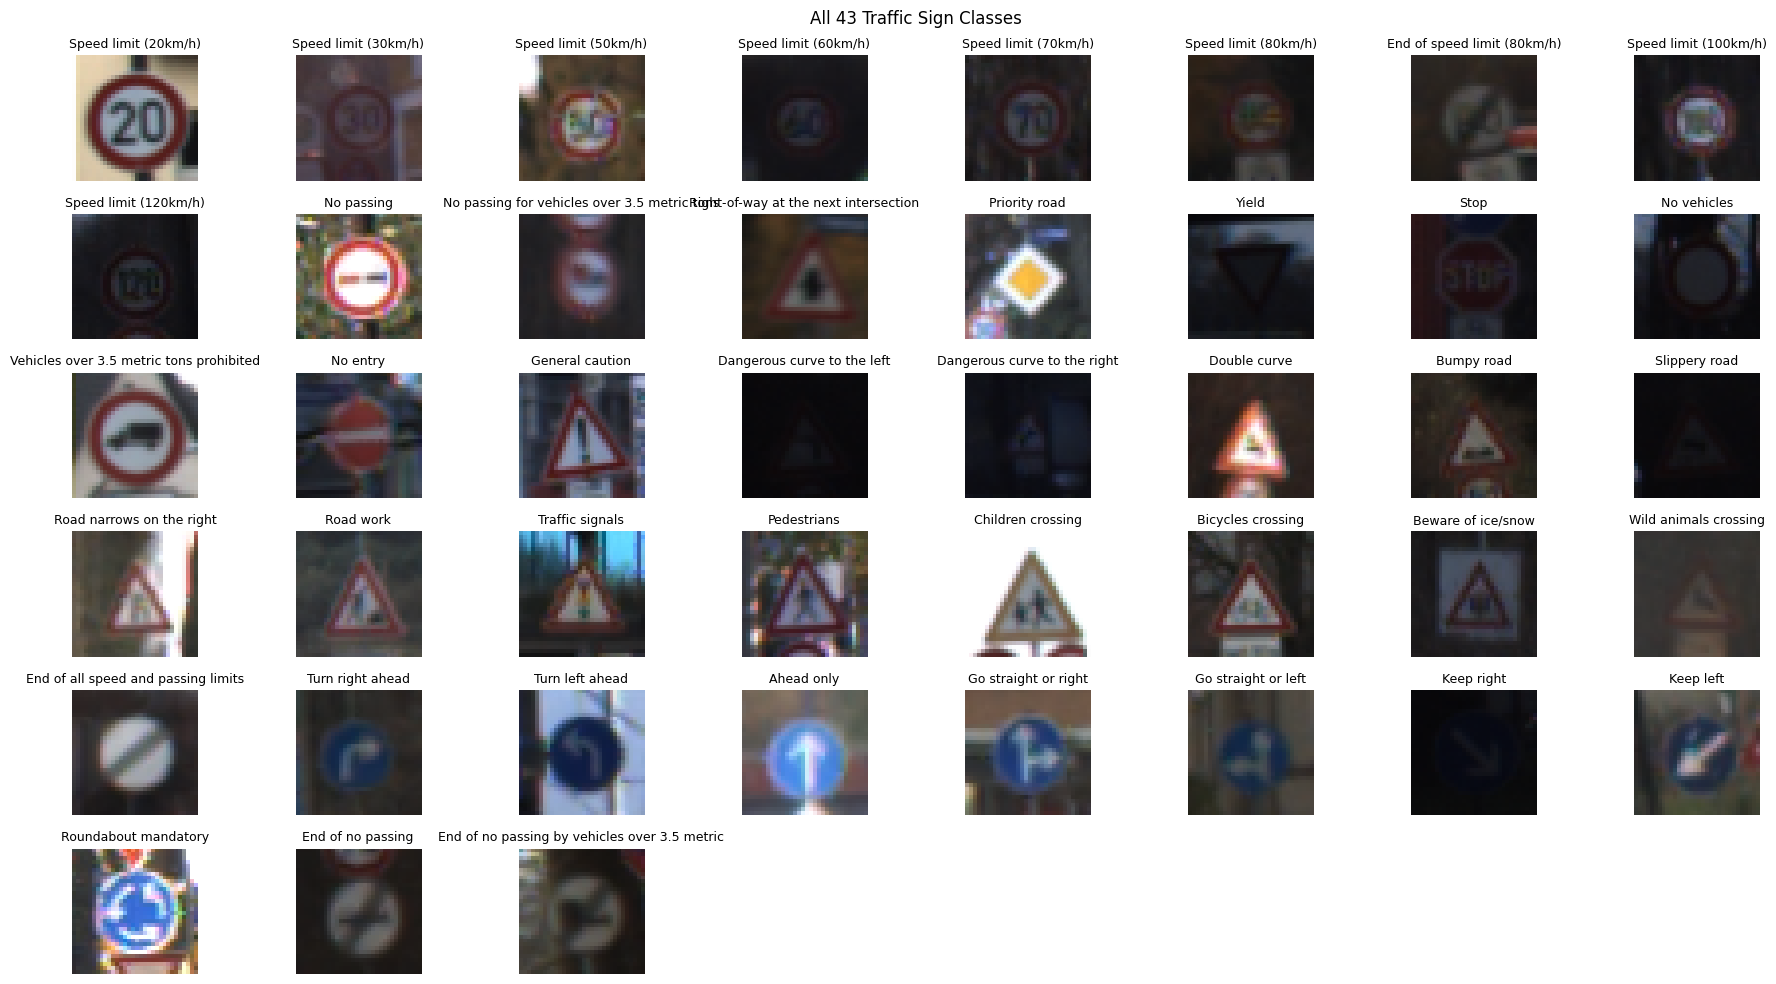

In [ ]:
# Show one sample per class
examples = {}
for i, label in enumerate(y_train):
    if label not in examples:
        examples[label] = i
    if len(examples) == NUM_CLASSES:
        break

plt.figure(figsize=(18, 10))
for i, (label, idx) in enumerate(sorted(examples.items())):
    plt.subplot(6, 8, i+1)
    plt.imshow(X_train[idx])
    plt.title(sign_names[y_train[idx]], fontsize=9)
    plt.axis('off')
plt.suptitle('All 43 Traffic Sign Classes')
plt.tight_layout()
plt.show()

---
## Part 3: Model 1 - Simple CNN

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

BATCH_SIZE = 32
train_gen = train_datagen.flow(X_train, y_train_oh, batch_size=BATCH_SIZE, shuffle=True)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid_oh, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Build Simple CNN
simple_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

simple_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
simple_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,043 (1.05 MB)

 Trainable params: 276,043 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train Simple CNN
cnn_ckpt = '/content/drive/MyDrive/TrafficSignProject/simple_cnn_best.h5'

cnn_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(cnn_ckpt, monitor='val_accuracy', save_best_only=True)
]

history_cnn = simple_cnn.fit(
    train_gen,
    epochs=15,
    validation_data=valid_gen,
    callbacks=cnn_callbacks
)

# Evaluate
cnn_loss, cnn_acc = simple_cnn.evaluate(X_test, y_test_oh, verbose=0)
print(f'\nSimple CNN Test Accuracy: {cnn_acc*100:.2f}%')

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2441 - loss: 2.7854

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.2442 - loss: 2.7848 - val_accuracy: 0.7837 - val_loss: 0.6694
Epoch 2/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7236 - loss: 0.8494

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.7236 - loss: 0.8492 - val_accuracy: 0.9243 - val_loss: 0.2839
Epoch 3/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8642 - loss: 0.4204

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.8642 - loss: 0.4204 - val_accuracy: 0.9612 - val_loss: 0.1751
Epoch 4/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9098 - loss: 0.2900 - val_accuracy: 0.9519 - val_loss: 0.2152
Epoch 5/15
1086/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9336 - loss: 0.2086

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9336 - loss: 0.2086 - val_accuracy: 0.9771 - val_loss: 0.1287
Epoch 6/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.9476 - loss: 0.1654 - val_accuracy: 0.9755 - val_loss: 0.0931
Epoch 7/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.9561 - loss: 0.1398 - val_accuracy: 0.9744 - val_loss: 0.1086
Epoch 8/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9633 - loss: 0.1166

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9633 - loss: 0.1166 - val_accuracy: 0.9785 - val_loss: 0.0859
Epoch 9/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.9688 - loss: 0.1043 - val_accuracy: 0.9751 - val_loss: 0.1351
Epoch 10/15
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9708 - loss: 0.0959

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.9708 - loss: 0.0959 - val_accuracy: 0.9828 - val_loss: 0.0806
Epoch 11/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.9757 - loss: 0.0800 - val_accuracy: 0.9807 - val_loss: 0.0701
Epoch 12/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9758 - loss: 0.0849 - val_accuracy: 0.9771 - val_loss: 0.0900
Epoch 13/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9773 - loss: 0.0736

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.9773 - loss: 0.0736 - val_accuracy: 0.9873 - val_loss: 0.0428
Epoch 14/15
 653/1088 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9792 - loss: 0.0754

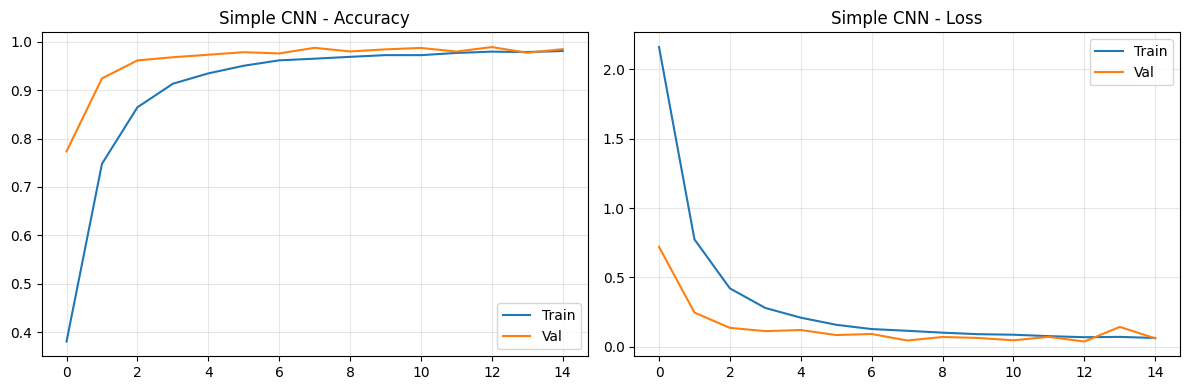

In [ ]:
# Plot CNN Training
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history_cnn.history['accuracy'], label='Train')
ax[0].plot(history_cnn.history['val_accuracy'], label='Val')
ax[0].set_title('Simple CNN - Accuracy')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(history_cnn.history['loss'], label='Train')
ax[1].plot(history_cnn.history['val_loss'], label='Val')
ax[1].set_title('Simple CNN - Loss')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

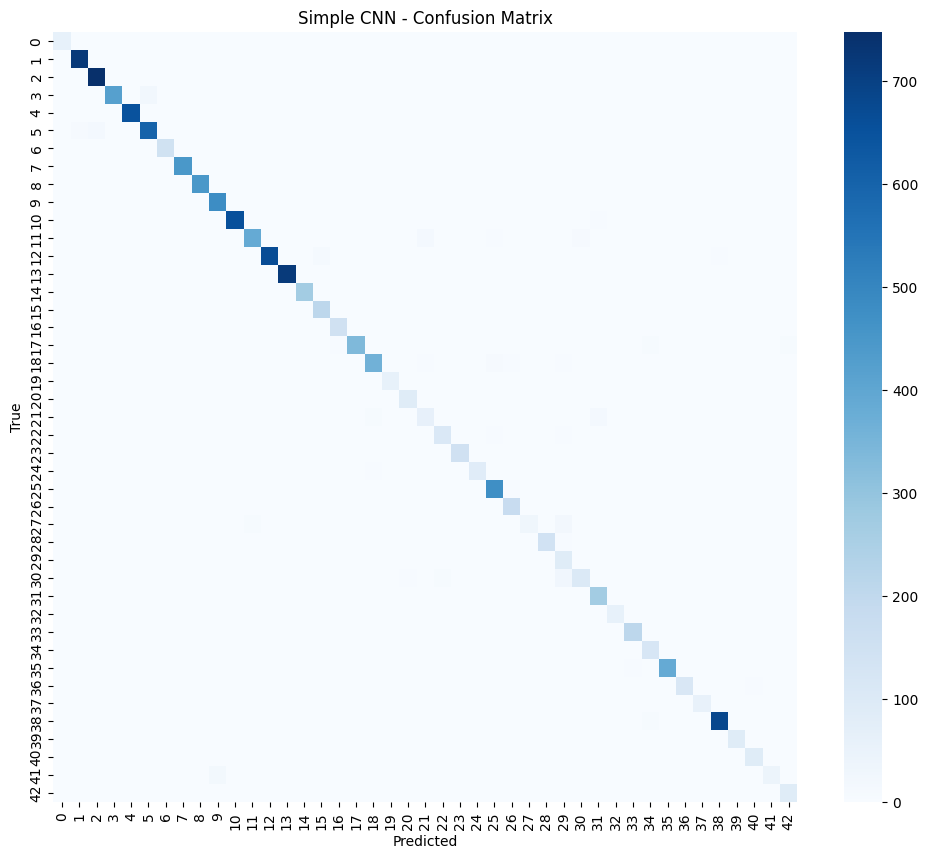

              precision    recall  f1-score   support

           0      0.984     1.000     0.992        60
           1      0.980     0.999     0.989       720
           2      0.974     0.997     0.986       750
           3      0.998     0.938     0.967       450
           4      1.000     0.985     0.992       660
           5      0.948     0.952     0.950       630
           6      0.993     0.993     0.993       150
           7      0.991     0.996     0.993       450
           8      0.987     0.998     0.992       450
           9      0.964     1.000     0.982       480
          10      1.000     0.992     0.996       660
          11      0.982     0.921     0.951       420
          12      0.997     0.968     0.982       690
          13      0.996     0.994     0.995       720
          14      1.000     1.000     1.000       270
          15      0.945     0.990     0.967       210
          16      0.968     1.000     0.984       150
          17      1.000    

In [ ]:
# CNN Confusion Matrix
y_pred_cnn = np.argmax(simple_cnn.predict(X_test, verbose=0), axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), cmap='Blues', annot=False)
plt.title('Simple CNN - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test, y_pred_cnn, digits=3))

---
## Part 4: Model 2 - MobileNetV2 (Transfer Learning)

In [ ]:
# Resize images for MobileNetV2 (needs larger input)
IMG_SIZE = 96

def resize_images(X, size):
    resized = np.zeros((len(X), size, size, 3), dtype=np.float32)
    for i in range(len(X)):
        resized[i] = cv2.resize(X[i], (size, size))
    return resized

X_train_m = resize_images(X_train, IMG_SIZE)
X_valid_m = resize_images(X_valid, IMG_SIZE)
X_test_m = resize_images(X_test, IMG_SIZE)

print(f'Resized: {X_train_m.shape}')

In [ ]:
# Build MobileNetV2 Model (lightweight version)
# NOTE: Using Rescaling layer instead of Lambda for better model serialization
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    alpha=0.35  # Smallest variant
)
base_model.trainable = False  # Freeze base

# Build model WITHOUT Lambda layers (for better serialization)
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# Rescaling: converts [0,1] to [-1,1] (MobileNetV2 expected range)
x = layers.Rescaling(scale=2.0, offset=-1.0)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

mobile_model = models.Model(inputs, outputs)
mobile_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
mobile_model.summary()

In [ ]:
# Data generators for MobileNet
train_datagen_m = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.08
)

train_gen_m = train_datagen_m.flow(X_train_m, y_train_oh, batch_size=BATCH_SIZE, shuffle=True)
valid_gen_m = ImageDataGenerator().flow(X_valid_m, y_valid_oh, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Train MobileNetV2 (frozen base)
mobile_ckpt = '/content/drive/MyDrive/TrafficSignProject/mobilenetv2_best.h5'

mobile_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True),
    ModelCheckpoint(mobile_ckpt, monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history_mobile = mobile_model.fit(
    train_gen_m,
    epochs=10,
    validation_data=valid_gen_m,
    callbacks=mobile_callbacks
)

# Evaluate
mobile_loss, mobile_acc = mobile_model.evaluate(X_test_m, y_test_oh, verbose=0)
print(f'\nMobileNetV2 Test Accuracy: {mobile_acc*100:.2f}%')

In [ ]:
# OPTIONAL: Fine-tune MobileNetV2
# Set to True if you want better accuracy (takes longer)
FINE_TUNE = True

if FINE_TUNE:
    print('Fine-tuning last 30 layers...')
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    mobile_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_ft = mobile_model.fit(
        train_gen_m,
        epochs=8,
        validation_data=valid_gen_m,
        callbacks=mobile_callbacks
    )

    mobile_loss, mobile_acc = mobile_model.evaluate(X_test_m, y_test_oh, verbose=0)
    print(f'Fine-tuned Accuracy: {mobile_acc*100:.2f}%')
else:
    print('Fine-tuning skipped (set FINE_TUNE=True to enable)')

In [ ]:
# Plot MobileNet Training
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history_mobile.history['accuracy'], label='Train')
ax[0].plot(history_mobile.history['val_accuracy'], label='Val')
ax[0].set_title('MobileNetV2 - Accuracy')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(history_mobile.history['loss'], label='Train')
ax[1].plot(history_mobile.history['val_loss'], label='Val')
ax[1].set_title('MobileNetV2 - Loss')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# MobileNet Confusion Matrix
y_pred_mobile = np.argmax(mobile_model.predict(X_test_m, verbose=0), axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_mobile), cmap='Greens', annot=False)
plt.title('MobileNetV2 - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test, y_pred_mobile, digits=3))

---
## Part 5: Model Comparison

In [ ]:
# Compare Models
print('='*50)
print('MODEL COMPARISON')
print('='*50)
print(f'Simple CNN:   {cnn_acc*100:.2f}% accuracy')
print(f'MobileNetV2:  {mobile_acc*100:.2f}% accuracy')
print(f'\nParameters:')
print(f'Simple CNN:   {simple_cnn.count_params():,}')
print(f'MobileNetV2:  {mobile_model.count_params():,}')

# Bar chart comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
names = ['Simple CNN', 'MobileNetV2']
colors = ['steelblue', 'forestgreen']

# Accuracy
accs = [cnn_acc*100, mobile_acc*100]
bars1 = ax[0].bar(names, accs, color=colors)
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Test Accuracy')
ax[0].set_ylim(0, 100)
for b, a in zip(bars1, accs):
    ax[0].text(b.get_x()+b.get_width()/2, b.get_height()+1, f'{a:.1f}%', ha='center', fontweight='bold')

# Loss
losses = [cnn_loss, mobile_loss]
bars2 = ax[1].bar(names, losses, color=colors)
ax[1].set_ylabel('Loss')
ax[1].set_title('Test Loss')
for b, l in zip(bars2, losses):
    ax[1].text(b.get_x()+b.get_width()/2, b.get_height()+0.02, f'{l:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

best = 'Simple CNN' if cnn_acc > mobile_acc else 'MobileNetV2'
print(f'\nBest Model: {best}')

---
## Part 6: Test with Custom Image

In [ ]:
# Upload and predict custom image
from google.colab import files

print('Upload a traffic sign image:')
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert('RGB')

    # Simple CNN prediction (32x32)
    img_cnn = np.array(img.resize((32, 32))).astype('float32') / 255.0
    pred_cnn = simple_cnn.predict(img_cnn.reshape(1, 32, 32, 3), verbose=0)
    cls_cnn = np.argmax(pred_cnn)

    # MobileNet prediction (96x96)
    img_mob = np.array(img.resize((IMG_SIZE, IMG_SIZE))).astype('float32') / 255.0
    pred_mob = mobile_model.predict(img_mob.reshape(1, IMG_SIZE, IMG_SIZE, 3), verbose=0)
    cls_mob = np.argmax(pred_mob)

    # Display
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Uploaded Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.7, f'Simple CNN: {sign_names[cls_cnn]}', ha='center', fontsize=11)
    plt.text(0.5, 0.5, f'Confidence: {pred_cnn[0][cls_cnn]*100:.1f}%', ha='center', fontsize=10)
    plt.text(0.5, 0.3, f'MobileNet: {sign_names[cls_mob]}', ha='center', fontsize=11)
    plt.text(0.5, 0.1, f'Confidence: {pred_mob[0][cls_mob]*100:.1f}%', ha='center', fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

---
## Part 7: Save Models

In [ ]:
# Save final models
simple_cnn.save('/content/drive/MyDrive/TrafficSignProject/simple_cnn_final.h5')
mobile_model.save('/content/drive/MyDrive/TrafficSignProject/mobilenetv2_final.h5')

print('Models saved!')
print('- simple_cnn_final.h5')
print('- mobilenetv2_final.h5')

In [ ]:
# Final Summary
print('='*50)
print('PROJECT COMPLETE')
print('='*50)
print(f'''
Dataset: GTSRB ({NUM_CLASSES} classes)
Train: {len(X_train)} | Valid: {len(X_valid)} | Test: {len(X_test)}

Simple CNN:   {cnn_acc*100:.2f}% (32x32 input)
MobileNetV2:  {mobile_acc*100:.2f}% (96x96 input)

Best: {best}
''')

In [ ]:
# Cleanup
del X_train_m, X_valid_m
gc.collect()
print('Memory cleaned up')

## Download Model



In [ ]:
# Add this cell at the end of your notebook
from google.colab import files
files.download('/content/drive/MyDrive/TrafficSignProject/simple_cnn_final.h5')
files.download('/content/drive/MyDrive/TrafficSignProject/mobilenetv2_final.h5')

